In [1]:
import os
import itertools
import time

import jax
from jax import jit, grad, jacrev, vmap
from jax.ops import index, index_update
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from scipy.constants import epsilon_0 as eps_0, mu_0


from scripts.loader import load_antenna_el_properties
from scripts.misc import fig_config, rmse, mae
from scripts.nc_utils import (central_difference, holoborodko,
                              elementwise_quad as equad,
                              elementwise_dblquad as edblquad)

In [2]:
# jax config
jax.config.update("jax_enable_x64", True)

In [3]:
# matplotlib config
%config InlineBackend.figure_format = 'retina'
R = 'crimson'
B = 'royalblue'
G = 'mediumseagreen'

# 1 Toy example

Consider a smooth one dimensional function, $f$, written as follows

$$ f(x) = \sin(\sin(2x)), $$ for $x \in [-1, 1]$.

Its first derivative is given in the following analytical expression:

$$ \frac{df}{dx} = 2 \cos(2x) \cos(\sin(2x)), $$

and its second derivative:

$$ \frac{d^2f}{dx} = - 4 \cdot \Big(\sin\big(\sin(2x)\big) \cos^2(2x) + \sin(2x) \cos\big(\sin(2x)\big)\Big).$$

Lets compare two different numerical differentiation approaches, concretely finite differentiation versus automatic differentiation.

In [4]:
def f(x):
    return jnp.sin(jnp.sin(2 * x))

def df(x):
    return 2 * jnp.cos(2 * x) * jnp.cos(jnp.sin(2 * x))

def ddf(x):
    return - 4. * (jnp.sin(jnp.sin(2 * x)) * jnp.cos(2 * x) ** 2
                   + jnp.sin(2 * x) * jnp.cos(jnp.sin(2 * x)))


df_ad = vmap(grad(f))
ddf_ad = vmap(grad(grad(f)))


df_fd = central_difference(f, order=1)
ddf_fd = central_difference(f, order=2)

In [5]:
x = jnp.linspace(-1, 1, 21)
ms = range(-15, -1)
ds = [0.25, 0.5, 0.75, 1]
deltas = [float(f'{d}e{m}') for m, d in itertools.product(ms, ds)]
dy_fd_rmse_list = []
ddy_fd_rmse_list = []
for delta in deltas:
    df_fd = central_difference(f, order=1, delta=delta)
    ddf_fd = central_difference(f, order=2, delta=delta)
    dy_fd_rmse_list.append(rmse(df_fd(x), df(x)))
    ddy_fd_rmse_list.append(rmse(ddf_fd(x), ddf(x)))

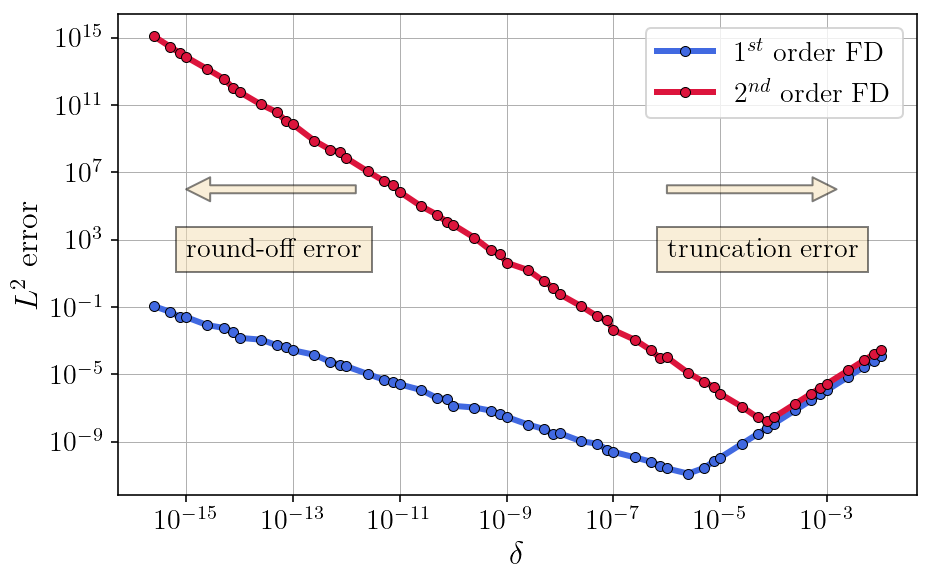

In [6]:
fig_config(latex=True, scaler=1.5)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.loglog(deltas, dy_fd_rmse_list, '.-', c=B, label='$1^{st}$ order FD')
ax.loglog(deltas, ddy_fd_rmse_list, '.-', c=R, label='$2^{nd}$ order FD')
ax.annotate('', xy=(1e-15, 10e5), xytext=(1.5e-12, 10e5), 
            arrowprops={'facecolor': 'wheat', 'alpha': 0.5})
ax.annotate('', xy=(1.5e-3, 10e5), xytext=(1e-6, 10e5), 
            arrowprops={'facecolor': 'wheat', 'alpha': 0.5})
ax.text(1e-15, 10e1, 'round-off error',
        bbox={'facecolor': 'wheat', 'alpha': 0.5, 'pad': 5})
ax.text(1e-6, 10e1, 'truncation error',
        bbox={'facecolor': 'wheat', 'alpha': 0.5, 'pad': 5})
ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'$L^{2}$ error')
ax.grid()
ax.legend()
plt.show()

In [7]:
fname = 'fig1a'
fig.savefig(os.path.join('figures', f'{fname}.pdf'),
            transparent=True,
            bbox_inches='tight', pad_inches=0.1)

In [8]:
x = jnp.linspace(-1, 1, 21)
y = f(x)
dy = df(x)
dy_ad = df_ad(x)
dy_fd = df_fd(x)
ddy = ddf(x)
ddy_ad = ddf_ad(x)
ddy_fd = ddf_fd(x)

dy_ad_rmse = rmse(dy, dy_ad)
dy_fd_rmse = rmse(dy, dy_fd)
ddy_ad_rmse = rmse(ddy, ddy_ad)
ddy_fd_rmse = rmse(ddy, ddy_fd)

In [9]:
print(f'1st order AD, RMSE {dy_ad_rmse:.2f}')
print(f'1st order FD, RMSE {dy_fd_rmse:.2e}')
print(f'2nd order AD, RMSE {ddy_ad_rmse:.2f}')
print(f'2nd order FD, RMSE {ddy_fd_rmse:.2e}')

1st order AD, RMSE 0.00
1st order FD, RMSE 1.16e-04
2nd order AD, RMSE 0.00
2nd order FD, RMSE 2.84e-04


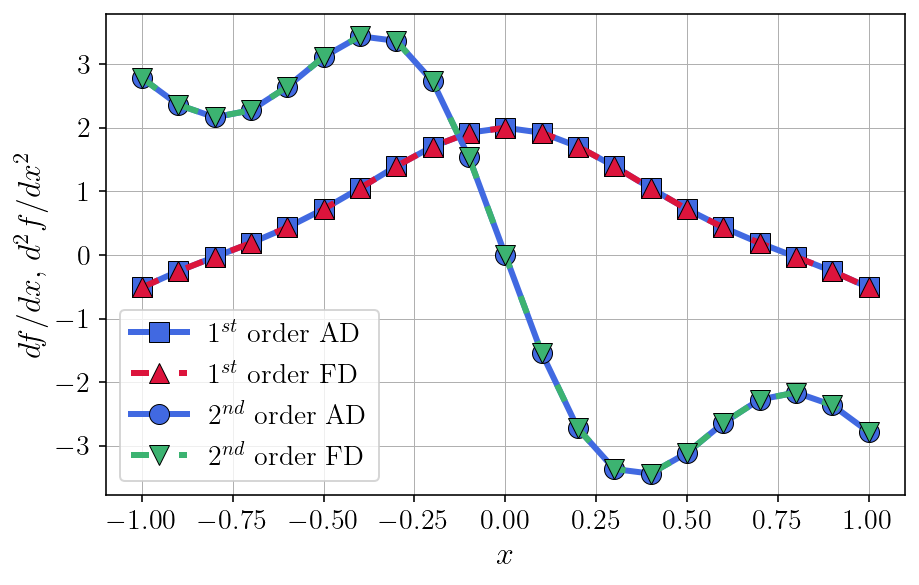

In [10]:
fig_config(latex=True, scaler=1.5)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, dy_ad, 's-', color=B, label=f'$1^{{st}}$ order AD')
ax.plot(x, dy_fd, '^--', color=R, label=f'$1^{{st}}$ order FD')
ax.plot(x, ddy_ad, 'o-', color=B, label=f'$2^{{nd}}$ order AD')
ax.plot(x, ddy_fd, 'v--', color=G, label=f'$2^{{nd}}$ order FD')
ax.set_xlabel('$x$')
ax.set_ylabel('$df / dx$, $d^2f / dx^2$')
ax.legend()
ax.grid()
plt.show()

In [11]:
fname = 'fig1b'
fig.savefig(os.path.join('figures', f'{fname}.pdf'), transparent=True,
            bbox_inches='tight', pad_inches=0.1)

# 2 Working example

Determining incident power density on the human skin model (free space approximation).
The following code demonstrate automatic differentiation capabilitis and its superiority over finite difference scheme when differentiating the Green function in free space in E and H field.

In [12]:
# frequency
f = 15e9

# antenna electric properties (Poljak 2005)
antenna_data = load_antenna_el_properties(f)
Is = antenna_data.ireal.to_numpy() + antenna_data.iimag.to_numpy() * 1j
dx = antenna_data.x[1] - antenna_data.x[0]
Is_x = holoborodko(Is, dx)

# antenna position -- coordinates
xs = antenna_data.x.to_numpy()
xs = jnp.asarray(xs)
ys = jnp.zeros_like(xs)
zs = jnp.zeros_like(xs)

# effective radiated skin area
target_area = (0.02, 0.02)  # 2 x 2 cm2
A = target_area[0] * target_area[1]
d = - 10 / 1000  # distance from the antenna
N = [21, 21, 21]
xt = jnp.linspace(-target_area[0]/2, target_area[0]/2, N[0]) + xs[-1] / 2
yt = jnp.linspace(-target_area[1]/2, target_area[1]/2, N[1])
zt = jnp.array([d])

## 2.1 Central difference approach

In [13]:
def green_fd(xt, yt, zt, xs, ys, zs, omega):
    k = jnp.sqrt(omega ** 2 * eps_0 * mu_0)
    R = jnp.sqrt((xt - xs) ** 2 + (yt - ys) ** 2 + (zt - zs) ** 2)
    return jnp.exp(-1j * k * R) / R

In [14]:
def ipd_fd(xt, yt, zt, xs, ys, zs, Is, Is_x, f, delta=1e-4):
    omega = 2 * np.pi * f
    gamma = 1j * np.sqrt(omega ** 2 * mu_0 * eps_0)
    e_prefix = 1 / (1j * 4 * np.pi * omega * eps_0)
    g = green_fd(xt, yt, zt, xs, ys, zs, omega)
    g_x = central_difference(green_fd, axis='x',
                             args=(yt, zt, xs, ys, zs, omega), delta=delta)(xt)
    # g_y = central_difference(green_fd, axis='y',
    #                          args=(xt, zt, xs, ys, zs, omega), delta=delta)(yt)
    g_z = central_difference(green_fd, axis='z',
                             args=(xt, yt, xs, ys, zs, omega), delta=delta)(zt)
    # e-field
    Ex = e_prefix * (- equad(Is_x * g_x, xs, 3)
                     - gamma ** 2 * equad(Is * g, xs, 3))
    # Ey = prefix * (equad(Is_x * g_y, xs, 3))
    # Ez = prefix * (equad(Is_x * g_z, xs, 3))

    # h-field
    h_prefix = 1 / (4 * np.pi)
    Hy = h_prefix * equad(Is * g_z, xs, 3)
    # Hz = - prefix * equad(Is * g_y, xs, 3)
    # Hx = np.zeros_like(Hz)
    
    return np.sqrt(np.power(Ex * Hy.conj(), 2))

In [15]:
start = time.perf_counter()

Sinc_fd = np.empty((xt.size, yt.size, zt.size), dtype=np.complex128)
for x_idx, _xt in enumerate(xt):
    for y_idx, _yt in enumerate(yt):
        for z_idx, _zt in enumerate(zt):
            Sinc_fd[x_idx, y_idx, z_idx] = ipd_fd(_xt, _yt, _zt, xs, ys, zs, Is, Is_x, f)
            
end = time.perf_counter()
elapsed = end - start
print(f'Execution time: {elapsed:.2f} s')

Execution time: 14.74 s


In [16]:
Sinc_dist_fd = np.abs(Sinc_fd)
Sab_fs_fd = 1 / (2 * A) * edblquad(np.real(Sinc_fd), xt, yt, 11)
print(f'{Sab_fs_fd = :.6f} W/m2')

Sab_fs_fd = 3.180408 W/m2


## 2.2 Automatic differentiation approach

In [17]:
def green_ad(T, xs, ys, zs, omega):
    k = jnp.sqrt(omega ** 2 * eps_0 * mu_0)
    R = jnp.sqrt((T[0] - xs) ** 2 + (T[1] - ys) ** 2 + (T[2] - zs) ** 2)
    return jnp.exp(-1j * k * R) / R

In [18]:
green_ad = jit(green_ad)
green_jac = jit(jacrev(green_ad, holomorphic=True))

In [19]:
def ipd_ad(xt, yt, zt, xs, ys, zs, Is, Is_x, f):
    omega = 2 * np.pi * f
    gamma = 1j * np.sqrt(omega ** 2 * mu_0 * eps_0)
    g = green_ad(np.asarray([xt + 0j, yt + 0j, zt + 0j]), xs, ys, zs, omega)
    J = green_jac(np.asarray([xt + 0j, yt + 0j, zt + 0j]), xs, ys, zs, omega)
    # e-field
    e_prefix = 1 / (1j * 4 * jnp.pi * omega * eps_0)
    Ex = e_prefix * (- equad(Is_x * J[:, 0], xs, 3)
                     - gamma ** 2 * equad(Is * g, xs, 3))
    # Ey = e_prefix * (equad(Is_x * J[:, 1], xs, 3))
    # Ez = e_prefix * (equad(Is_x * J[:, 2], xs, 3))
    # h-field
    h_prefix = 1 / (4 * np.pi)
    Hy = h_prefix * equad(Is * J[:, 2], xs, 3)
    # Hz = - h_prefix * equad(Is * J[:, 1], xs, 3)
    # Hx = np.zeros_like(Hz)
    return np.sqrt(jnp.power(Ex * Hy.conj(), 2))

In [20]:
start = time.perf_counter()

Sinc_ad = np.empty((xt.size, yt.size, zt.size), dtype=np.complex128)
for x_idx, _xt in enumerate(xt):
    for y_idx, _yt in enumerate(yt):
        for z_idx, _zt in enumerate(zt):
            Sinc_ad[x_idx, y_idx, z_idx] = ipd_ad(_xt, _yt, _zt, xs, ys, zs, Is, Is_x, f)
            
end = time.perf_counter()
elapsed = end - start
print(f'Execution time: {elapsed:.2f} s')

Execution time: 10.66 s


In [21]:
Sinc_dist_ad = np.abs(Sinc_ad)
Sab_fs_ad = 1 / (2 * A) * edblquad(np.real(Sinc_ad), xt, yt, 31)

## 2.3 Evaluation

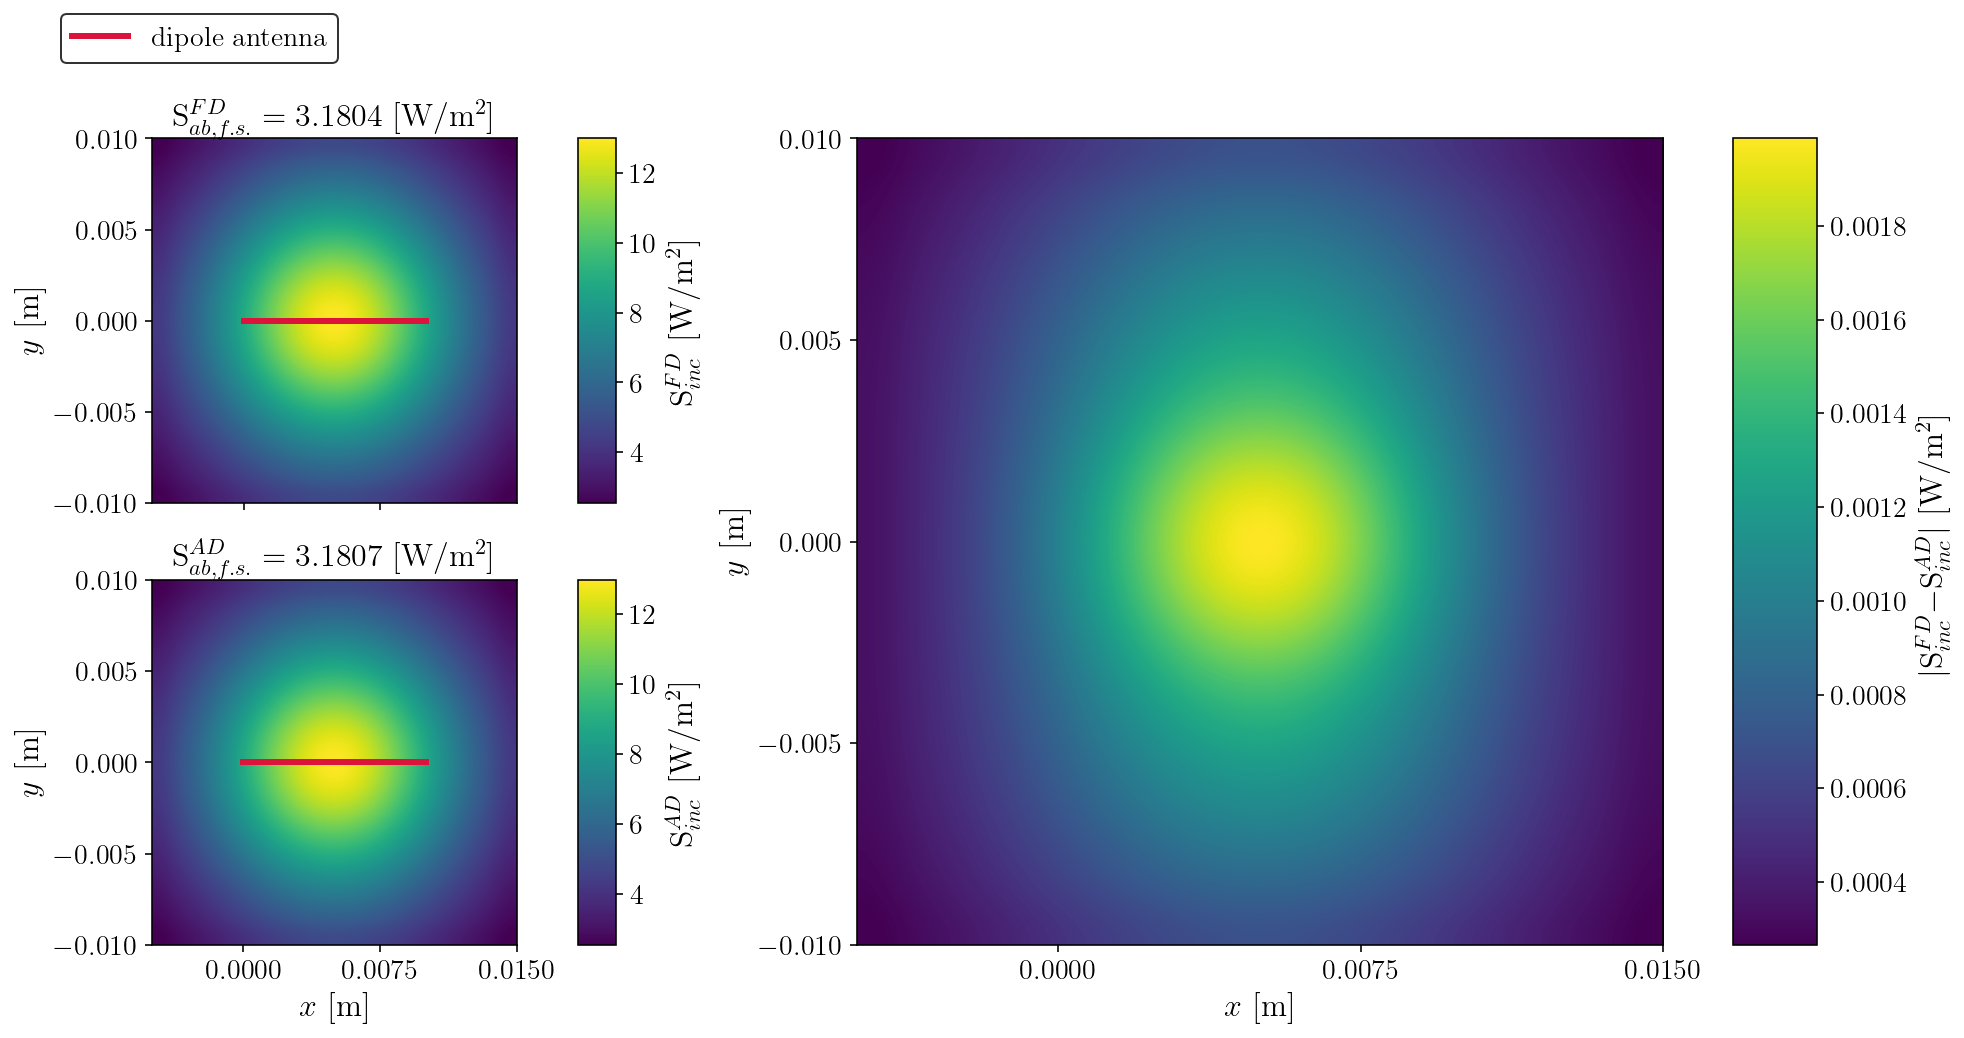

In [22]:
interp = 'spline36'
extent = (xt.min(), xt.max(), yt.min(), yt.max())
difference = np.abs(Sinc_fd - Sinc_ad)

fig_config(latex=True, scaler=1.5)
fig = plt.figure(constrained_layout=True, figsize=(13.5, 6.5))
gs = fig.add_gridspec(nrows=2, ncols=3)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
ax3 = fig.add_subplot(gs[0:, 1:])

cs1 = ax1.imshow(Sinc_dist_fd, interpolation=interp, extent=extent)
cbar1 = fig.colorbar(cs1, ax=ax1)
cbar1.ax.set_ylabel('S$_{inc}^{FD}$ [W/m$^2$]')
ax1.plot(xs, ys, '-', color='crimson', label='dipole antenna')
ax1.set_title(f'S$_{{ab, f.s.}}^{{FD}} = {Sab_fs_fd:.4f}$ [W/m$^2$]')
ax1.set_xticks([0.0, 0.0075, 0.015])
ax1.set_yticks([-0.01, -0.005, 0.0, 0.005, 0.01])
ax1.set_ylabel('$y$ [m]')

cs2 = ax2.imshow(Sinc_dist_ad, interpolation=interp, extent=extent)
cbar2 = fig.colorbar(cs2, ax=ax2)
cbar2.ax.set_ylabel('S$_{inc}^{AD}$ [W/m$^2$]')
ax2.plot(xs, ys, '-', color='crimson', linewidth=3)
ax2.set_title(f'S$_{{ab, f.s.}}^{{AD}} = {Sab_fs_ad.item():.4f}$ [W/m$^2$]')
ax2.set_xticks([0.0, 0.0075, 0.015])
ax2.set_yticks([-0.01, -0.005, 0.0, 0.005, 0.01])
ax2.set_xlabel('$x$ [m]')
ax2.set_ylabel('$y$ [m]')

cs3 = ax3.imshow(difference, interpolation=interp, extent=extent)
cbar3 = fig.colorbar(cs3, ax=ax3)
cbar3.ax.set_ylabel('$|$S$_{inc}^{FD} - $S$_{inc}^{AD}|$ [W/m$^2$]')
ax3.set_xticks([0.0, 0.0075, 0.015])
ax3.set_yticks([-0.01, -0.005, 0.0, 0.005, 0.01])
ax3.set_xlabel('$x$ [m]')
ax3.set_ylabel('$y$ [m]')

fig.legend(bbox_to_anchor=(0.175, 1.1), frameon=True, edgecolor='k')
plt.setp(ax1.get_xticklabels(), visible=False)
plt.show()

In [23]:
fname = 'fig2'
fig.savefig(os.path.join('figures', f'{fname}.pdf'),
            transparent=True,
            bbox_inches='tight', pad_inches=0.1)

# 3 Comprehensive simulation

Propagation of the round-off error in central difference scheme over the range of mmWave frequencies.
Automatic differentiation is considered as the ground truth.

In [24]:
target_area = (0.02, 0.02)
A = target_area[0] * target_area[1]
d = -15 / 1000
N = [21, 21, 21]
f_list = [3., 6., 10., 15., 20., 30., 40., 60., 80., 100.]
delta_list = [1e-3, 0.5e-3, 1e-4]

In [25]:
def ad_sim(f):
    omega = 2 * jnp.pi * f
    gamma = 1j * jnp.sqrt(omega ** 2 * mu_0 * eps_0)
    antenna_data = load_antenna_el_properties(f)
    Is = antenna_data.ireal.to_numpy() + antenna_data.iimag.to_numpy() * 1j
    Is = jnp.asarray(Is)
    dx = antenna_data.x[1] - antenna_data.x[0]
    Is_x = holoborodko(Is, dx)
    Is_x = jnp.asarray(Is_x)
    xs = antenna_data.x.to_numpy()
    xs = jnp.asarray(xs)
    ys = jnp.zeros_like(xs)
    zs = jnp.zeros_like(xs)
    xt = jnp.linspace(-target_area[0]/2, target_area[0]/2, N[0]) + xs[-1] / 2
    yt = jnp.linspace(-target_area[1]/2, target_area[1]/2, N[1])
    zt = jnp.array([d])
    Sab_dist = jnp.empty((xt.size, yt.size, zt.size))
    for x_idx, _xt in enumerate(xt):
        for y_idx, _yt in enumerate(yt):
            for z_idx, _zt in enumerate(zt):
                g = green_ad(np.asarray([_xt, _yt, _zt]), xs, ys, zs, omega)
                J = green_jac(np.asarray([_xt + 0j, _yt + 0j, _zt + 0j]), xs, ys, zs, omega)
                Ex = (1 / (1j * 4 * jnp.pi * omega * eps_0)
                      * (- equad(Is_x * J[:, 0], xs, 3)
                         - gamma ** 2 * equad(Is * g, xs, 3)))
                Hy = 1 / (4 * jnp.pi) * equad(Is * J[:, 2], xs, 3)
                Sab_dist = index_update(Sab_dist, index[x_idx, y_idx, z_idx],
                    np.real(np.sqrt(np.power(Ex * Hy.conj(), 2))))
    return 1 / (2 * A) * edblquad(Sab_dist, xt, yt, 31)

In [26]:
Sab_fs_ad_list = []
for f in f_list:
    Sab_fs_ad_list.append(ad_sim(f * 1e9))

In [27]:
def fd_sim(f, delta):
    omega = 2 * np.pi * f
    gamma = 1j * np.sqrt(omega ** 2 * mu_0 * eps_0)
    antenna_data = load_antenna_el_properties(f)
    Is = antenna_data.ireal.to_numpy() + antenna_data.iimag.to_numpy() * 1j
    dx = antenna_data.x[1] - antenna_data.x[0]
    Is_x = holoborodko(Is, dx)
    xs = antenna_data.x.to_numpy()
    ys = np.zeros_like(xs)
    zs = np.zeros_like(xs)
    xt = np.linspace(-target_area[0]/2, target_area[0]/2, N[0]) + xs[-1] / 2
    yt = np.linspace(-target_area[1]/2, target_area[1]/2, N[1])
    zt = np.array([d])
    Sab_dist = np.empty((xt.size, yt.size, zt.size))
    for x_idx, _xt in enumerate(xt):
        for y_idx, _yt in enumerate(yt):
            for z_idx, _zt in enumerate(zt):
                g = green_fd(_xt, _yt, _zt, xs, ys, zs, omega)
                g_x = central_difference(green_fd, axis='x',
                    args=(_yt, _zt, xs, ys, zs, omega), delta=delta)(_xt)
                g_z = central_difference(green_fd, axis='z',
                    args=(_xt, _yt, xs, ys, zs, omega), delta=delta)(_zt)
                Ex = (1 / (1j * 4 * np.pi * omega * eps_0)
                      * (- equad(Is_x * g_x, xs, 3)
                         - gamma ** 2 * equad(Is * g, xs, 3)))
                Hy = 1 / (4 * np.pi) * equad(Is * g_z, xs, 3)
                Sab_dist[x_idx, y_idx, z_idx] = np.real(
                    np.sqrt(np.power(Ex * Hy.conj(), 2)))
    return 1 / (2 * A) * edblquad(Sab_dist, xt, yt, 31)

In [28]:
Sab_fs_fd_dict = {}
for delta in delta_list:
    Sab_fs_fd_list = []
    for f in f_list:
        Sab_fs_fd_list.append(fd_sim(f * 1e9, delta))
        Sab_fs_fd_dict[delta] = Sab_fs_fd_list

In [29]:
RMSE_dict = {}
for key, val in Sab_fs_fd_dict.items():
    RMSE_dict[key] = rmse(np.asarray(Sab_fs_ad_list), np.asarray(val))

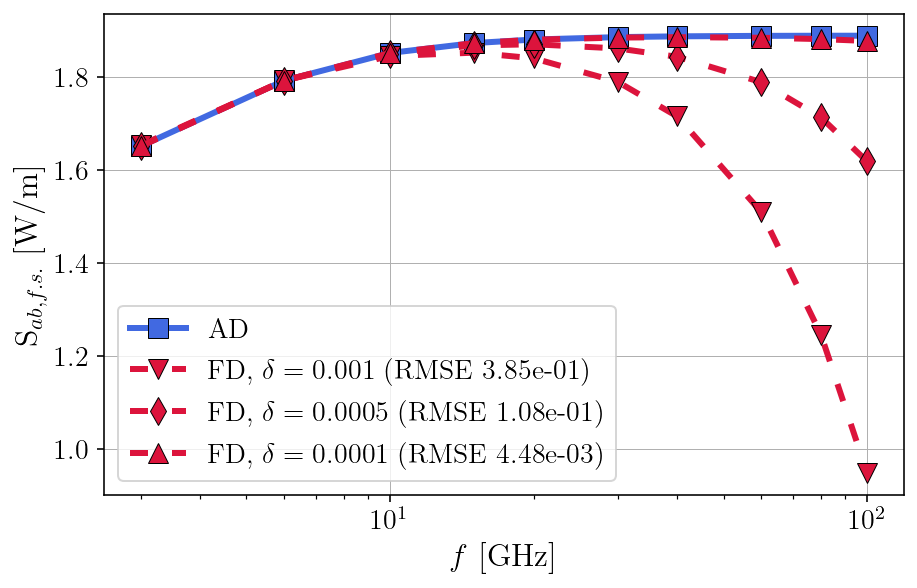

In [30]:
marker_list = ['v', 'd', '^']

fig_config(latex=True, scaler=1.5)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(f_list, Sab_fs_ad_list, 's-', color=B, label=f'AD')
for delta, marker in zip(delta_list, marker_list):
    ax.plot(f_list, Sab_fs_fd_dict[delta], '-', dashes=(3, 4), marker=marker,
            color=R,
            label=f'FD, $\\delta = {delta}$ (RMSE {RMSE_dict[delta]:.2e})')
ax.set_xlabel(r'$f$ [GHz]')
ax.set_ylabel(r'S$_{ab, f.s.}$ [W/m]')
ax.set_xscale('log')
ax.legend()
ax.grid()
plt.show()

In [31]:
fname = 'fig3'
fig.savefig(os.path.join('figures', f'{fname}.pdf'),
            transparent=True,
            bbox_inches='tight', pad_inches=0.1)

# 4 Execution speed comparison

Calculating the full Jacobian matrix for the Green function.

In [32]:
def green(xt, yt, zt, xs, ys, zs, omega):
    k = jnp.sqrt(omega ** 2 * eps_0 * mu_0)
    R = jnp.sqrt((xt - xs) ** 2 + (yt - ys) ** 2 + (zt - zs) ** 2)
    return jnp.exp(-1j * k * R) / R

green_grad = jit(vmap(grad(green, argnums=(0, 1, 2), holomorphic=True),
                      in_axes=(None, None, None, 0, 0, 0, None)))

In [33]:
def ad_sim():
    for x_idx, _xt in enumerate(xt):
            for y_idx, _yt in enumerate(yt):
                for z_idx, _zt in enumerate(zt):
                    g_x, gy, gz = green_grad(_xt + 0j, _yt + 0j, _zt + 0j, xs, ys, zs, 2 * np.pi * f)

In [34]:
def fd_sim():
    for x_idx, _xt in enumerate(xt):
            for y_idx, _yt in enumerate(yt):
                for z_idx, _zt in enumerate(zt):
                    g_x = central_difference(green, axis='x',
                                             args=(_yt, _zt, xs, ys, zs, 2 * np.pi * f), delta=delta)(_xt)
                    g_y = central_difference(green, axis='y',
                                             args=(_xt, _zt, xs, ys, zs, 2 * np.pi * f), delta=delta)(_yt)
                    g_z = central_difference(green, axis='z',
                                             args=(_xt, _yt, xs, ys, zs, 2 * np.pi * f), delta=delta)(_zt)

In [35]:
ad_time = %timeit -o ad_sim()
fd_time = %timeit -o fd_sim()

250 ms ± 1.65 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
7.28 s ± 68.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [36]:
speedup = []
for ad_sim_single_exec in ad_time.all_runs:
    for fd_sim_single_exec in fd_time.all_runs:
        speedup.append(fd_sim_single_exec / ad_sim_single_exec)
speedup_avg = np.mean(speedup)
speedup_std = np.std(speedup)
print(f'Speed-up = {speedup_avg:.2f}s ± {speedup_std:.2f} s')

Speed-up = 29.13s ± 0.33 s


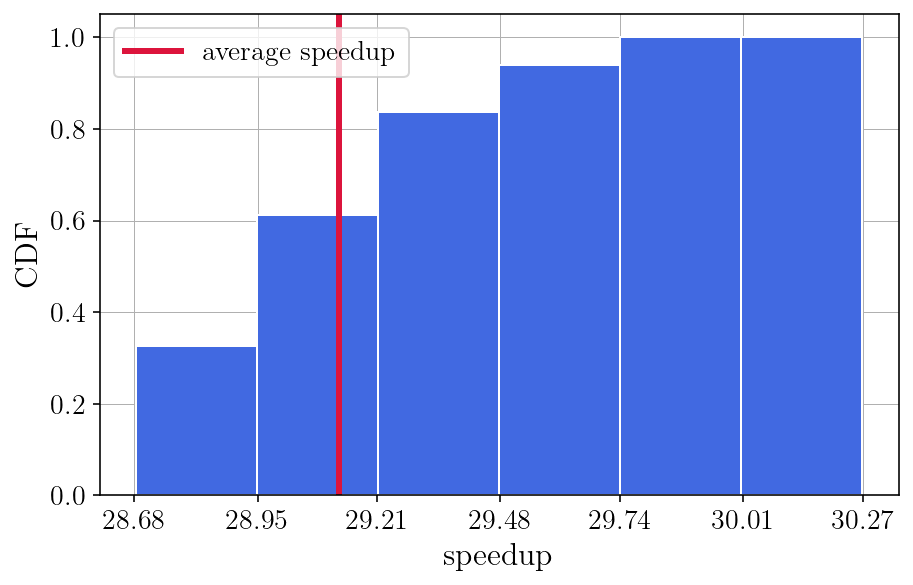

In [37]:
iqr = np.subtract(*np.percentile(speedup, [75, 25]))
bin_width = (2 * iqr) / np.power(len(speedup), 1/3)
speedup_range = max(speedup) - min(speedup)
bin_number = int((speedup_range / bin_width) + 1)
bin_step = speedup_range/bin_number
bins = np.arange(min(speedup), max(speedup) + bin_step, bin_step)

fig_config(latex=True, scaler=1.5)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(speedup, bins=bins, ec='white', fc=B, density=True, cumulative=True, zorder=2)
ax.axvline(x=speedup_avg, ymin=0, ymax=1, c=R, label='average speedup')
ax.set_xticks(np.round(bins, decimals=2))
ax.set_xlabel('speedup')
ax.set_ylabel('CDF')
ax.legend()
ax.grid(zorder=0)
plt.show()

In [38]:
fname = 'fig4'
fig.savefig(os.path.join('figures', f'{fname}.pdf'),
            transparent=True,
            bbox_inches='tight', pad_inches=0.1)